In [1]:
# Imports
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.optimizers import SGD

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
# Import raw data
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2021-02-02 20:30:55--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  56.1MB/s    in 3.7s    

2021-02-02 20:30:59 (51.3 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [3]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [4]:
df = pd.read_csv("ml-20m/ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
# Use our own ids to make sure that they are consistant
df.userId = pd.Categorical(df.userId)
df["new_user_id"] = df.userId.cat.codes

In [6]:
# Now do same for movie ids
df.movieId = pd.Categorical(df.movieId)
df["new_movie_id"] = df.movieId.cat.codes

In [7]:
# Extract all values into arrays
user_ids = df["new_user_id"].values
movie_ids = df["new_movie_id"].values
ratings = df["rating"].values

In [8]:
# Get number of users and movies (to form the chart)
N = len(set(user_ids))
M = len(set(movie_ids))

# Embedding dims
K = 10

In [9]:
# Create the network

# User input
u = Input(shape=(1,))

# Movie input
m = Input(shape=(1,))

# User/movie embeding (converts to encoded value similar to 1-hot encoding)
u_emb = Embedding(N, K)(u)
m_emb = Embedding(M, K)(m)

# Flatten both embeddings
u_emb = Flatten()(u_emb)
m_emb = Flatten()(m_emb)

# Combine the two inputs
x = Concatenate()([u_emb, m_emb])  # Now the shape is num_samples, 2k

# Now continue as a regular ANN
x = Dense(1024, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)

# Create and compile the model
model = Model(inputs=[u, m], outputs=x)

model.compile(
    loss="mse",
    optimizer=SGD(lr=0.08, momentum=0.9),
    metrics=["accuracy"]
)

In [10]:
# Split the data
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# Average the ratings arround 0
avg_ratings = train_ratings.mean()
train_ratings -= avg_ratings
test_ratings -= avg_ratings

In [11]:
# Train the model
r = model.fit(
    x=[train_user, train_movie],
    y=train_ratings,
    epochs=25,
    batch_size=1024,
    verbose=2,
    validation_data=([test_user, test_movie], test_ratings))

Epoch 1/25
15626/15626 - 49s - loss: 1.0890 - accuracy: 0.0000e+00 - val_loss: 1.0232 - val_accuracy: 0.0000e+00
Epoch 2/25
15626/15626 - 47s - loss: 0.9860 - accuracy: 0.0000e+00 - val_loss: 0.9645 - val_accuracy: 0.0000e+00
Epoch 3/25
15626/15626 - 47s - loss: 0.9583 - accuracy: 0.0000e+00 - val_loss: 0.9586 - val_accuracy: 0.0000e+00
Epoch 4/25
15626/15626 - 46s - loss: 0.9529 - accuracy: 0.0000e+00 - val_loss: 0.9570 - val_accuracy: 0.0000e+00
Epoch 5/25
15626/15626 - 46s - loss: 0.9500 - accuracy: 0.0000e+00 - val_loss: 0.9552 - val_accuracy: 0.0000e+00
Epoch 6/25
15626/15626 - 46s - loss: 0.9473 - accuracy: 0.0000e+00 - val_loss: 0.9534 - val_accuracy: 0.0000e+00
Epoch 7/25
15626/15626 - 45s - loss: 0.9437 - accuracy: 0.0000e+00 - val_loss: 0.9501 - val_accuracy: 0.0000e+00
Epoch 8/25
15626/15626 - 46s - loss: 0.9393 - accuracy: 0.0000e+00 - val_loss: 0.9469 - val_accuracy: 0.0000e+00
Epoch 9/25
15626/15626 - 45s - loss: 0.9358 - accuracy: 0.0000e+00 - val_loss: 0.9452 - val_accu

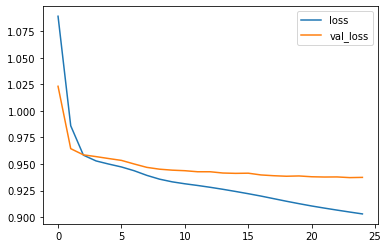

In [12]:
# Plot results
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

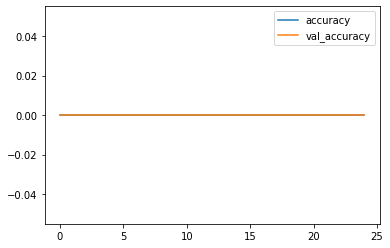

In [13]:
# Plot results
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()